# Machine Learning from the Ground Up

Today we will be creating a machine learning algorithm without relying on anything more than code we write ourselves and some basic calculus.

## Single-Variable Linear Least Squares

In the reading you saw the linear least squares approach to modeling the relationship between two variables.  In the reading, we saw the following model.

$y = wx + b + \epsilon$

Where $w$ is the slope of a line describing the relationship between x and y, $b$ is the y-intercept, and $\epsilon$ is an error term.  To make things even easier, we are going to consider an even more restrictive relationship between x and y.  Specifically, we will assume that the line describing the relationship between x and y goes through the origin (which implies $b = 0$).

$y = wx + \epsilon$

### Fitting a line to data

Suppose we are given a collection of independent variables $x_1, \ldots, x_n$ with each $x_i \in \mathbb{R}$ and corresponding dependent variables $y_1, \ldots, y_n$ with $y_i \in \mathbb{R}$.  You can think of the x's as height and y's as weight if that helps for concreteness.  We can write an error function that quantifies the sum of squared residuals (remember from the reading?).

$e(w) = \sum_{i=1}^n \left (wx_i - y_i\right)^2$

### An example dataset

Next, we will generate some data and examine the geometry of the function $e$.  In order to generate some data, we will use a built-in function scikit learn for generating synthetic datasets.  Synthetic datasets are ones where the relationship between inputs and outputs is known.  These datasets can be good for debugging machine learning algorithms.

True slope 78.7879277871


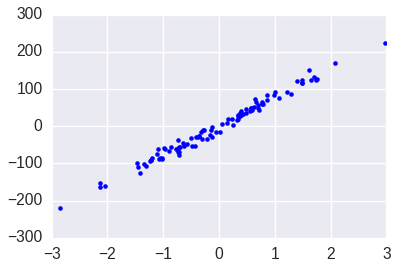

In [109]:
%matplotlib inline
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

x, y, coef = make_regression(n_samples=100, n_features=1, noise=10, coef=True)
print "True slope", coef
plt.plot(x,y,'b.')
plt.show()

Next, plot $e(w)$.  What shape does the function have?

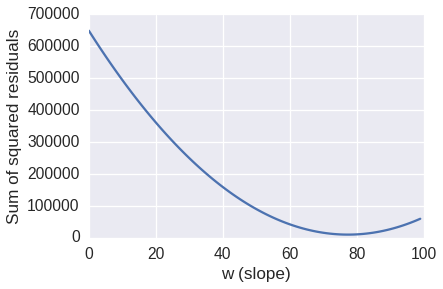

In [110]:
def error(w, x, y):
    """ Calculate the sum of squared residuals.  The data points
        x and y that are implicit inputs to the our function e
        passed as additional inputs to the Python function error
    """
    return np.sum([(y[i] - w*x[i,0])**2 for i in range(len(x))])

ws = np.arange(0,100,1)
plt.plot(ws, [error(w,x,y) for w in ws])
plt.xlabel("w (slope)")
plt.ylabel("Sum of squared residuals")
plt.show()

### Gradient Descent

As discussed in ThinkStats Chapter 10, if we want to have a good model relating x and y, we should choose the slope, $w$, that minimizes the function $e(w)$.

In order to find the minimum of $e(w)$ we will use gradient descent.  The basic idea, is to calculate the slope of the function $e(w)$ at some initial guess $w_0$.  We then adjust our guess $w_0$ by moving it in the opposite direction of the slope of the function using this formula.

$w_1 = w_0 - \alpha \frac{d}{dw}e(w_0)$

Where $\alpha$ is a positive constant that specifies the step size.  To build intuition, determine how the second guess at the slope $w_1$ would change depending on the slope of $e$ evaluated at $w_0$.

This procedure can be iterated to construct a series of guesses of the the value of $w$.

$w_t = w_{t-1} - \alpha \frac{d}{dw}e(w_{t-1})$

Next, create a function called `error_grad` that computes the derivative of `error` with respect to $w$.

In [111]:
def error_grad(w, x, y):
    """ Computes the derivative of the error with respect to
        the slope w"""
    return np.sum([2*(y[i] - w*x[i,0])*(-x[i,0]) for i in range(len(x))])

w_0 = 2
estimate = error_grad(w_0, x, y)
estimate

-16100.622278396255

#### Sanity Check

Use the concept of [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation) to make sure that your function `error_grad` is correct.

In [112]:
computed = (error(w_0+10**-6, x, y) - error(w_0, x, y))/10**-6
estimate - computed

-3.0491715733660385e-05

#### Implementation of Gradient Descent

Now that we are reasonably confident in our gradient computation, we can proceed to implement gradient descent.

77.4178806573


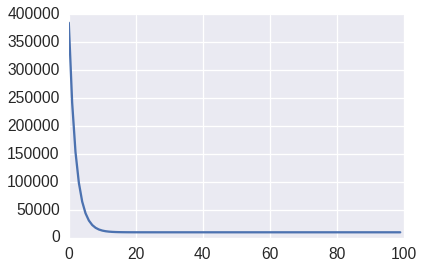

In [113]:
def gradient_descent(w, x, y, alpha, iters):
    errors = np.zeros((iters,1))
    for i in range(iters):
        w = w - alpha*error_grad(w, x, y)
        errors[i] = error(w, x, y)
    return w, errors

w_f, errors = gradient_descent(w_0, x, y, .001, 100)
print w_f
plt.plot(errors)

This basic approach to gradient descent is somewhat finicky.  Fortunately, we can do better by dynamically adjusting alpha depending on whether the error is increasing or decreasing.

77.4178806241


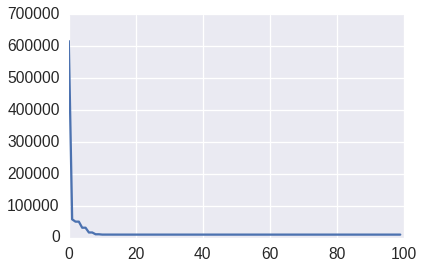

In [114]:
def gradient_descent(w, x, y, alpha, iters):
    errors = np.zeros((iters,1))
    last_error = error(w, x, y)
    for i in range(iters):
        w_proposed = w - alpha*error_grad(w, x, y)
        error_proposed = error(w_proposed, x, y)
        if error_proposed < last_error:
            last_error = error_proposed
            w = w_proposed
            alpha *= 1.5
        else:
            alpha *= 0.6
        errors[i] = last_error
            
    return w, errors

w_f, errors = gradient_descent(w_0, x, y, .01, 100)
print w_f
plt.plot(errors)

## Multivariate Linear Least Squares

All of the theory we just developed can be applied to the case where we have multiple independent variables that we'd like to use to model a single dependent variable.  In this case, we assume that the datapoints are now given as $x_1, \ldots, x_n$ with $x_i \in \mathbb{R}^d$.  As before we are also given corresponding targets $y_1, \ldots, y_n$ with $y_i \in \mathbb{R}$.  Now, the relationship between $y_i$ and $x_i$ is modeled as:

$y_i = \sum_{j=1}^d w_jx_i + \epsilon$

### Computing the Best Weights

In order to compute the best weights we have to define what we mean by best.  We will use the exact same notion of "error" that we used for the single variable case, that is the sum of squared errors.  To make this more concrete, let's load a dataset with multiple variables that we can use.

** NOTE: in this dataset the targets are numpy array of shape $(n,1)$ where $n$ is the number of examples this is different than in scikit learn where the dimensionality is simply $n,$.  I have not modified the smile dataset to conform to the scikit learn format, because I think things are much more straightforward with this convention.  If you want to go to the same convention as sklearn, just do `data.target = np.squeeze(data.target)`. **

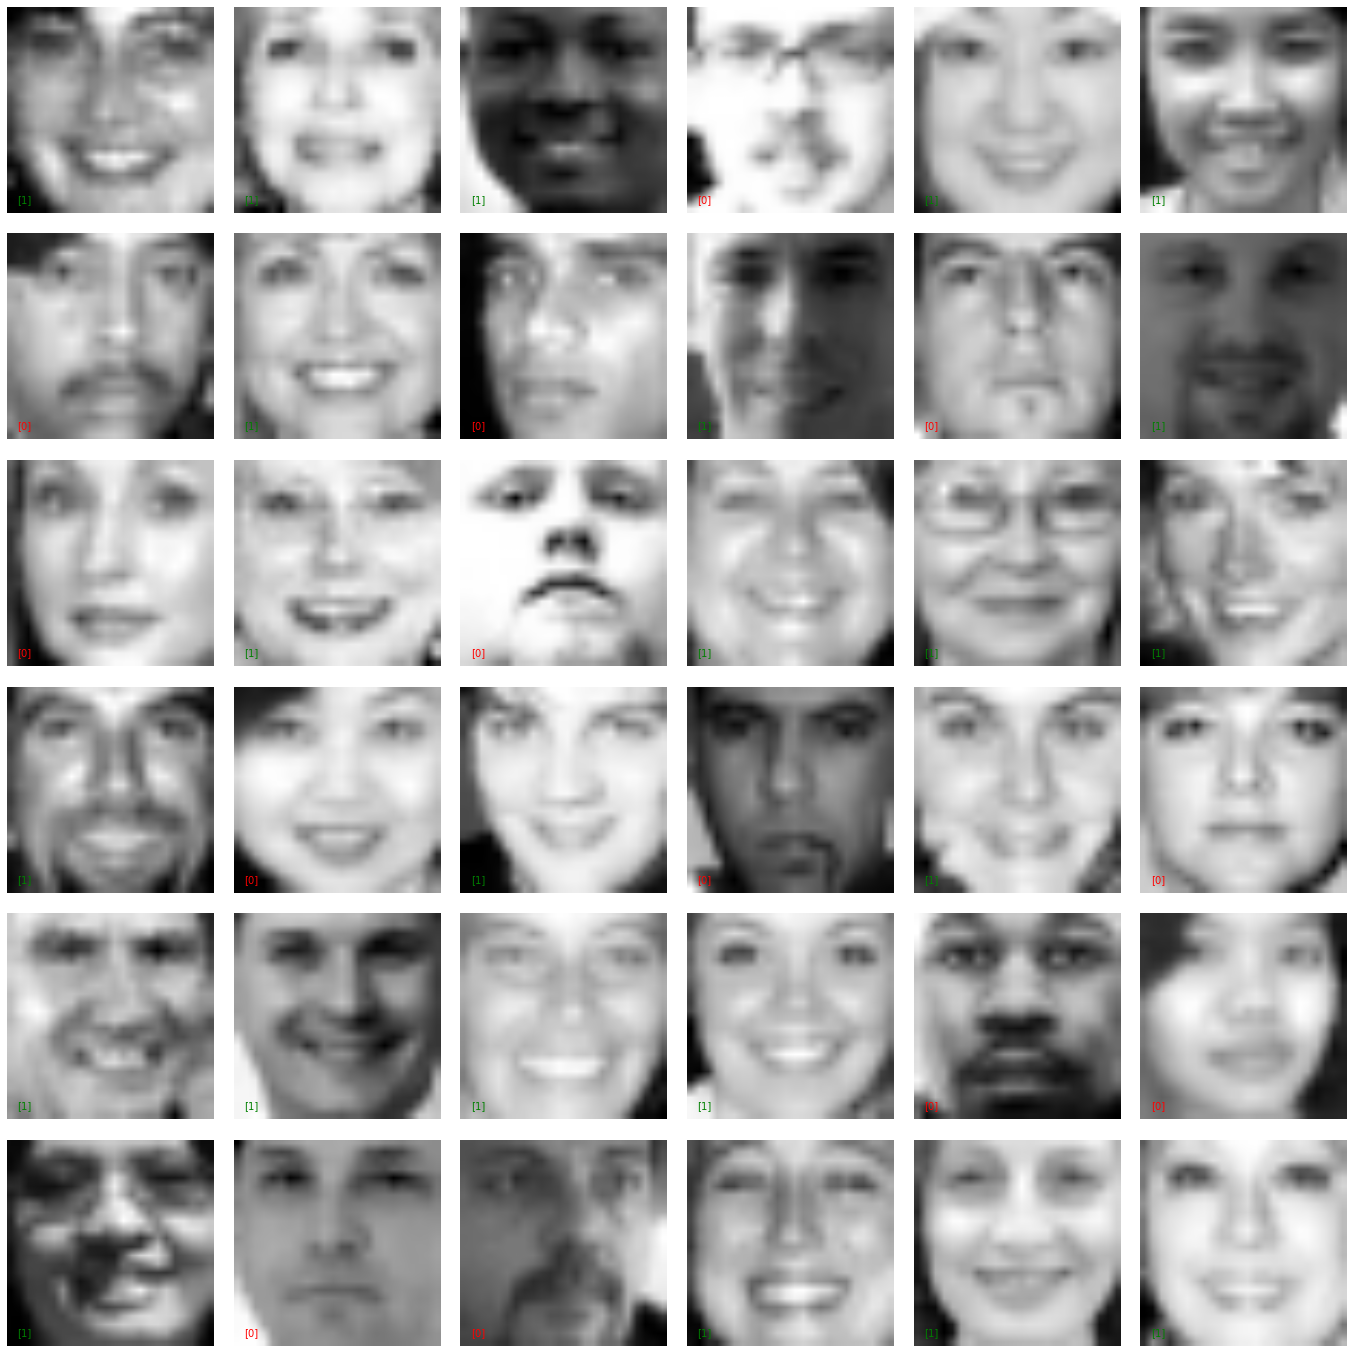

In [115]:
from load_smiles import load_smiles
import numpy as np

def show_smiles(images, targets):
    """ Adapted from Jake Vanderplas' scikit learn tutorials. """
    fig, axes = plt.subplots(6, 6, figsize=(24, 24))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i,:].reshape((24,24)).T, cmap='gray')
        ax.text(0.05, 0.05, str(targets[i]),
                transform=ax.transAxes,
                color='green' if (targets[i]) else 'red')
        ax.set_xticks([])
        ax.set_yticks([])

data = load_smiles()
X, y = data.data, data.target
show_smiles(X, y)

### Adapting the Single Variable Gradient Descent

The logic of multivariate gradient descent is identical to the single variable case.  The only difference is now instead of having a gradient with a single component (i.e. the derivative), we now have a gradient with many components (one for each feature).
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Gradient_descent.svg/512px-Gradient_descent.svg.png" width="30%"/>

In order to adapt your code from before to this new setting, at a high-level you will have to perform the following steps.

1.  Create a function called `error_multi` that is similar to `error` but that handles the case where X is an $n \times m$ matrix (where $n$ is the number of examples and $m$ is the number of features).
2.  Derive an expression for the gradient of this error function with respect to each of the components of $w$.  Remember, the gradient is a vector of all partial derivatives of the function.  Specifically, in this case:
$\nabla \mbox{error_multi}(w, X, y) = \begin{bmatrix} \frac{\partial}{\partial w_1} \mbox{error_multi}(w, X, y) \\  \frac{\partial}{\partial w_2} \mbox{error_multi}(w, X, y) \\ \vdots \\ \frac{\partial}{\partial w_d} \mbox{error_multi}(w, X, y) \end{bmatrix}$.
3.  Update the `gradient_descent` function to work with the new code that you've written.
4.  Split your data into training and testing data.
5.  Learn a smile detector!
6.  Evaluate its accuracy
7.  Improve your learning algorithm (this will be described later)

### Hints

If you'd like, here are some hints for each of the points above (with the exception of (7)).  Improvements to the learning algorithm are treated in the next section.

#### 1.

This is straightforward to do with a for loop, however, your code will be much more efficient if you use matrix multiplication to compute the predictions, and then numpy vector operations to compute the error.

#### 2.

You should start out at the whiteboard!  There are two ways to look at this problem.  One is to treat the matrices and vectors as simply containers of numbers.  In this approach, you can work out an expression for each component of the gradient with nothing more than basic single-variable calculus (with the twist that you have to think about which variable you are differentiating with respect to).  Once you have developed an expression for the partial derivatives, these can be assembled to make the gradient.

The second way to think of the problem is to treat the matrices and vectors as firt class objects.  There are expressions for the gradient of a function involving matrices and vectors that can be applied.  For hints, check out the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).

Once you've determined the expressions for the gradient, you should start implementing your equations.  If you choose the first method above, you will probably wind up with code that is pretty slow. To make it faster, try to see where certain values are being computed repeatedly.  If you can remove this redundancy, you can speed the computation up.

At all steps of the process, make sure to perform sanity checks.  The best one I find is comparing the numerically computed gradient to the one you compute in your function.  The logic is basically the same as we did for the single variable case.

#### 3.

This should be pretty straightforward.  I'd suggest starting from the adaptive code from above.

#### 4.

If you are confused, start out by writing some pseudocode.  Use the ipython notebook from day 3 to help (or consult your warmup project).

#### 6.

Again, your warmup project or the day 3 notebook should have everything you need.  As a fun twist, you can use the code in the last cell of this notebook to visualize the changing weights your program learns.  Make sure to return a list of all of the weights on a per-iteration basis so they can be passed into the widget at the end of the notebook.  In some cases you may need to use `np.copy` when adding the weights to the list in order to avoid having aliasing modify the values later.

In [116]:
def error_multi(w, X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    w = np.asarray(w)
    g = np.transpose(X)*w
    #print X.shape, w.shape, g.shape
    return np.sum((X.dot(w)-y)**2)

In [117]:
def error_grad_multi(w, X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    w = np.asarray(w)
    return np.transpose(X).dot(2*((X.dot(w)-y)))

In [118]:
def gradient_descent_multi(w, X, y, alpha, iters):
    errors = np.zeros((iters,1))
    last_error = error_multi(w, X, y)
    all_ws = []
    for i in range(iters):
        w_proposed = w - alpha*error_grad_multi(w, X, y)
        error_proposed = error_multi(w_proposed, X, y)
        if error_proposed < last_error:
            last_error = error_proposed
            w = w_proposed
            all_ws.append(w)
            alpha *= 1.5
        else:
            alpha *= 0.6
        errors[i] = last_error
            
    return w, errors, all_ws

In [119]:
def success_rate(w, X, y):
    w = np.asarray(w)
    X = np.asarray(X)
    y = np.asarray(y)
    predictions = np.asarray([1 if i > 0.5 else 0 for i in X.dot(w)])
    y = np.squeeze(y)
    predictions = np.squeeze(predictions)
    return ( np.sum(predictions == y) / float(len(y)) )

In [120]:
from sklearn.cross_validation import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

def test_smile_detector(X, y, w_0_multi):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
    w_f, errors, _ = gradient_descent_multi(w_0_multi, X_train, y_train, .01, 100)
    train_err = success_rate(w_f, X_train, y_train)
    test_err = success_rate(w_f, X_test, y_test)
    return w_f, errors, train_err, test_err

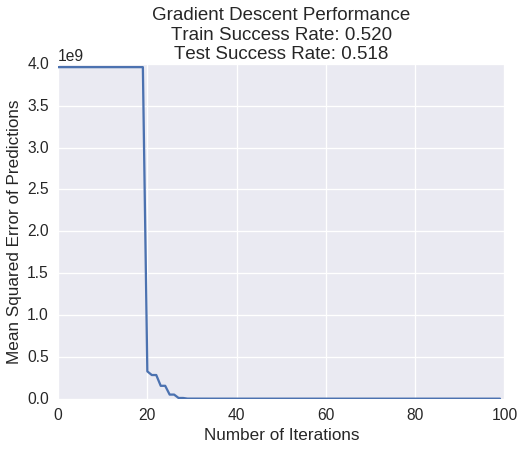

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(8, 6))

w_0_multi = np.zeros((X.shape[1], 1))+2

w_f, errors, train_err, test_err = test_smile_detector(X, y, w_0_multi)
plt.plot(errors);
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Error of Predictions")
plt.title("Gradient Descent Performance\nTrain Success Rate: {0:3.3f}\nTest Success Rate: {1:3.3f}".\
          format(train_err, test_err))
plt.show();

### Making Gradient Descent Better

There are quite a few suggestions for improving gradient descent.  Some of them have to do with changing the representation of your data, some have to do with your learning algorithm.

#### Add a bias term

One drawback of the way we have formulated linear regression is that we don't allow for a non-zero y-intercept.  You can simulate having a y-intercept by adding a column of all 1's to your data.  Before implementing this tweak, go to the whiteboard and convince yourself that the weight on this feature of all 1's can serve the same role as the term, $b$, in the equation $y = wx + b$.

#### rprop

The basic intuition is that having a single step size (also known as a learning rate) is too restrictive.  In this version we have a per parameter step size that is adapted on the fly.  If you recall, the way we adjusted our single step size was based on whether the error went down or up.  In this version, we have to use an indicator that can be applied to each dimension independently.  We use the sign of the partial derivative as this indicator.  If the sign of the partial derivative for a given dimension is consistent across two iterations, then we are probably still on the same side of a local minima, in this case we can go faster.  If the signs are different, then we have probably overshot and we should go slower.  This approach can also be combined with the idea of rejecting an update if it makes the error worse.  For more details see the [rprop Wikipedia page](https://en.wikipedia.org/wiki/Rprop).

#### Nesterov Accelerated Gradient

The Nesterov accelerated gradient algorithm is a beautiful algorithm that achieves an optimal convergence rate for certain functions.  The intuition is not nearly as straightforward as the others we've seen, but one can view it as adding a momentum term to the gradient.  Here is a [blog entry](https://blogs.princeton.edu/imabandit/2013/04/01/acceleratedgradientdescent/) talking about the algorithm and giving the updates.  Note: in this post you can consider $\beta$ to be some constant (similar to the step-size parameter we had originally).

#### Conjugate Gradient

The fastest algorithm for solving this problem is [conjugate gradient descent](https://en.wikipedia.org/wiki/Conjugate_gradient_method).  It's a bit harder to understand how to implement than the others, but I'm happy to go over it.  The basic idea is to look at the [Wikpedia page](https://en.wikipedia.org/wiki/Conjugate_gradient_method) specifically the section on Conjugate gradient as an iterative method.  You will be using that algorithm with $A = X^\top X$ and $b = X^\top y$.  This will get you the right answer, but it won't illuminate why the problem can be formulated this way.  The high-level intuition is your trying to solve for the weights that make the gradient of the sum of squared error equal to zero.  Ping me during work time if you want to know more.

#### Hints

For each algorithm, make sure to sketch out some pseudocode.  I'd say that rprop and Nesterov are easier implement, but I got better empirical results with conjugate gradient.

You should also make a plot that compare the progress of your method to the simple version of gradient descent.

### Visualizing your Model

Go ahead, use the code below to visualize the weights at each iteration of gradient descent.  Note that you must have a variable called `all_ws` that is a list of the value of `w` at each iteration of gradient descent.  I am not responsible for any nightmares this visualization might cause.

In [126]:
from ipywidgets import interact

def view_image(i):
    print len(all_ws)
    plt.imshow(all_ws[i].reshape((24,24)).T, cmap='gray', interpolation='nearest');
    #plt.imshow(all_ws[i][2:(24**2)+2].reshape((24,24)).T, cmap='gray', interpolation='nearest');
    plt.title('Training: %s' %i);

def view_image_with_extra(i):
    plt.imshow(all_ws[i][:(24**2)].reshape((24,24)).T, cmap='gray', interpolation='nearest');
    plt.title('Training: %s' %i);

def disp_interact(all_ws):
    interact(view_image, i=(0, len(all_ws)-1))

def disp_perf_descent(X, y):
    w_0_multi = np.ones((X.shape[1], 1))
    w_f, errors, all_ws = gradient_descent_multi(w_0_multi, X, y, .01, 100)
    disp_interact(all_ws)

In [127]:
disp_perf_descent(X, y)

45


ValueError: total size of new array must be unchanged